In [1]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import plot_histogram

In [2]:
n = 2
n_cube = pow(n, 3)
qb_per_process = int(np.ceil(np.log2(n_cube)))
total_qubits = n * qb_per_process

def generate_leader_circuit():
    qc = QuantumCircuit(total_qubits)
    qc.h(range(0, qb_per_process))

    for j in range(1,n):
        for i in range(0, qb_per_process):
            qc.cx(i, i + j * qb_per_process)
    qc.measure_all()
    return qc

def generate_coin_circuit():
    qc = QuantumCircuit(n)
    qc.h(0)
    qc.cx(0,range(1,n))
    qc.measure_all()    
    return qc

def measure_circuit_sampler(system):
    aer_sim = AerSimulator(method="stabilizer")
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(system)
    sampler = SamplerV2(backend=aer_sim)

    result = sampler.run([isa_qc], shots=None).result() # PubResult
    data_pub = result[0].data   # DataBin
    shots = data_pub.meas.num_shots
    counts = data_pub.meas.get_counts()  

    probs = {string:count/shots for string,count in counts.items()}
    return probs

In [3]:
leader_circuit = generate_leader_circuit()
leader_circuit.draw(output="latex_source")

'\\documentclass[border=2px]{standalone}\n\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{graphicx}\n\n\\begin{document}\n\\scalebox{1.0}{\n\\Qcircuit @C=1.0em @R=0.2em @!R { \\\\\n\t \t\\nghost{{q}_{0} :  } & \\lstick{{q}_{0} :  } & \\gate{\\mathrm{H}} & \\ctrl{3} & \\qw & \\qw \\barrier[0em]{5} & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{1} :  } & \\lstick{{q}_{1} :  } & \\gate{\\mathrm{H}} & \\qw & \\ctrl{3} & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{2} :  } & \\lstick{{q}_{2} :  } & \\gate{\\mathrm{H}} & \\qw & \\qw & \\ctrl{3} & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{3} :  } & \\lstick{{q}_{3} :  } & \\qw & \\targ & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw & \\qw & \\qw\\\\\n\t \t\\nghost{{q}_{4} :  } & \\lstick{{q}_{4} :  } & \\qw & \\qw & \\targ & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\meter & \\qw & \

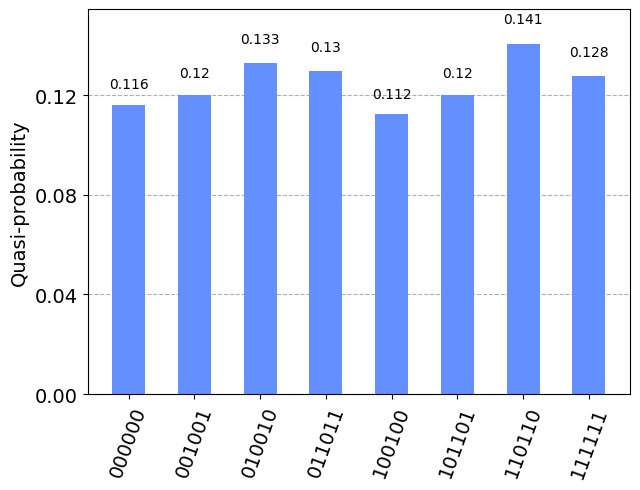

In [4]:
probabilities = measure_circuit_sampler(leader_circuit)
plot_histogram(probabilities, figsize=(7,5))

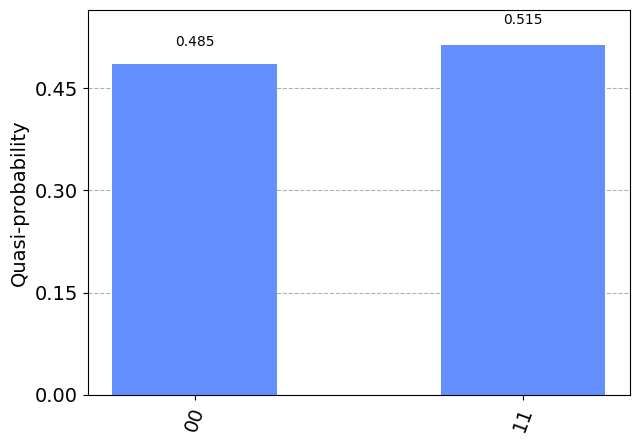

In [5]:
coin_circuit = generate_coin_circuit()
probs2 = measure_circuit_sampler(coin_circuit)
plot_histogram(probs2)